In [5]:
# data
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
import tensorflow as tf

# tqdm
from tqdm import tqdm_notebook as tqdm

tf.set_random_seed(777)  # reproducibility

# layers
from tensorflow.contrib.layers import fully_connected, batch_norm, dropout
from tensorflow.contrib.framework import arg_scope

In [1]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
combine = [train_df, test_df]

# for self-test
result_df = pd.read_csv('./data/sample_submission.csv')

NameError: name 'pd' is not defined

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
train_df.describe()

In [ ]:
test_df.describe()

In [ ]:
train_df.columns

In [ ]:
train_df['SalePrice'].describe()

In [ ]:
sns.distplot(train_df['SalePrice'])

In [ ]:
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

In [ ]:
data = pd.concat([train_df['SalePrice'], train_df['TotalBsmtSF']], axis=1)
data.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0, 800000))

In [ ]:
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000);

In [ ]:
#box plot overallqual/saleprice
var = 'OverallCond'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [ ]:
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In [ ]:
corrmat = train_df.corr()
corrmat

In [ ]:
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=1.0, square=True);

In [ ]:
k_number = 10
cols = corrmat.nlargest(k_number, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                yticklabels=cols.values, xticklabels=cols.values)

In [ ]:
sns.set()
cols = corrmat.nlargest(k_number, 'SalePrice')['SalePrice'].index
sns.pairplot(train_df[cols], size=1.5)

In [ ]:
train_df.describe(include=['O'])

In [78]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [79]:
train_df[(missing_data[(missing_data['Percent'] < 0.15) & (missing_data['Percent'] > 0)]).index].head()

,GarageCond,GarageType,GarageYrBlt,GarageFinish,GarageQual,BsmtExposure,BsmtFinType2,BsmtFinType1,BsmtCond,BsmtQual,MasVnrArea,MasVnrType,Electrical
0,TA,Attchd,2003.0,RFn,TA,No,Unf,GLQ,TA,Gd,196.0,BrkFace,SBrkr
1,TA,Attchd,1976.0,RFn,TA,Gd,Unf,ALQ,TA,Gd,0.0,None,SBrkr
2,TA,Attchd,2001.0,RFn,TA,Mn,Unf,GLQ,TA,Gd,162.0,BrkFace,SBrkr
3,TA,Detchd,1998.0,Unf,TA,No,Unf,ALQ,Gd,TA,0.0,None,SBrkr
4,TA,Attchd,2000.0,RFn,TA,Av,Unf,GLQ,TA,Gd,350.0,BrkFace,SBrkr


In [80]:
train_df = train_df.drop((missing_data[missing_data['Total'] > 1]).index, 1)
train_df = train_df.drop(train_df.loc[train_df['Electrical'].isnull()].index)

In [81]:
train_df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [82]:
saleprice_scaled = StandardScaler().fit_transform(train_df['SalePrice'][:, np.newaxis]);

/Users/outtoin/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [83]:
low_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[ 3.82758058]
 [ 4.0395221 ]
 [ 4.49473628]
 [ 4.70872962]
 [ 4.728631  ]
 [ 5.06034585]
 [ 5.42191907]
 [ 5.58987866]
 [ 7.10041987]
 [ 7.22629831]]


In [84]:
train_df[['Id', 'GrLivArea']].sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,GrLivArea
1298,1299,5642
523,524,4676


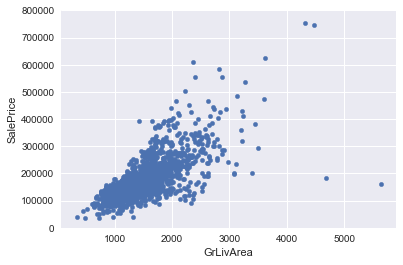

In [85]:
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [86]:
IndexOfGrLivAreaOL = train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 700000)].index
IndexOfGrLivAreaOL

Int64Index([523, 1298], dtype='int64')

In [87]:
train_df = train_df.drop(IndexOfGrLivAreaOL)

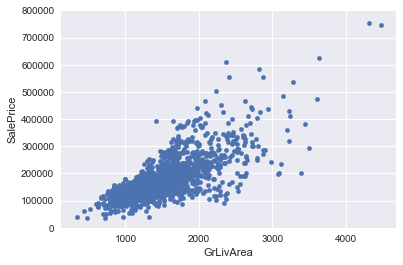

In [88]:
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

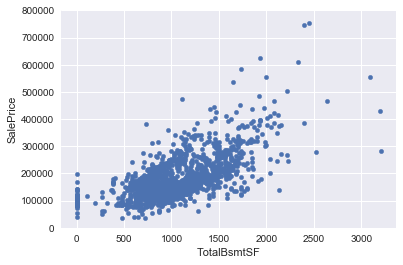

In [89]:
var = 'TotalBsmtSF'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [90]:
IndexOfTotalBsmtSFOL = train_df[(train_df['TotalBsmtSF'] > 3000) & (train_df['SalePrice'] < 500000)].index
IndexOfTotalBsmtSFOL

Int64Index([332, 496], dtype='int64')

In [91]:
train_df = train_df.drop(IndexOfTotalBsmtSFOL)

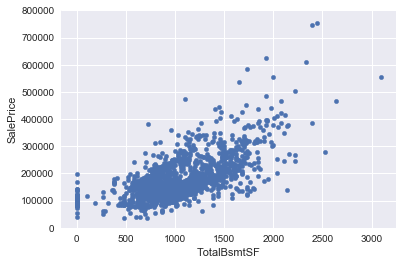

In [92]:
var = 'TotalBsmtSF'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

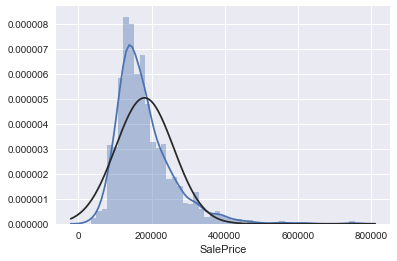

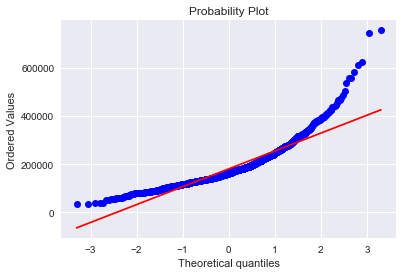

In [93]:
sns.distplot(train_df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)

In [ ]:
train_df['SalePrice'] = np.log(train_df['SalePrice'])

combine = [train_df, test_df]

In [ ]:
sns.distplot(train_df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)

In [ ]:
sns.distplot(train_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['GrLivArea'], plot=plt)

In [94]:
train_df['GrLivArea'] = np.log(train_df['GrLivArea'])
test_df['GrLivArea'] = np.log(test_df['GrLivArea'])
    
combine = [train_df, test_df]

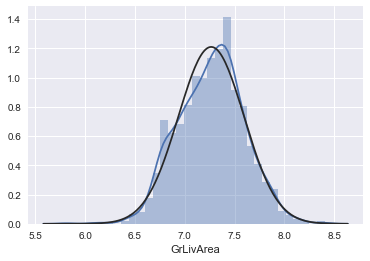

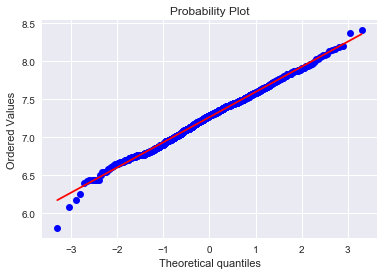

In [95]:
sns.distplot(train_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['GrLivArea'], plot=plt)

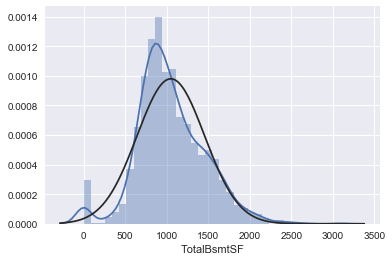

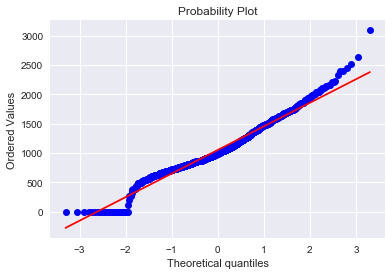

In [96]:
sns.distplot(train_df['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['TotalBsmtSF'], plot=plt)

In [97]:
for dataset in combine:
    dataset['TotalBsmtSF'] = np.log(dataset['TotalBsmtSF'])
    
combine = [train_df, test_df]

/Users/outtoin/.pyenv/versions/3.5.2/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [106]:
train_df['TotalBsmtSF']

0       6.752270
1       7.140453
2       6.824374
3       6.628041
4       7.043160
5       6.679599
6       7.430114
7       7.009409
8       6.858565
9       6.898715
10      6.946976
11      7.069023
12      6.815640
13      7.309212
14      7.133296
15      6.723832
16      6.911747
17      0.000000
18      7.015712
19      6.936343
20      7.054450
21      6.456770
22      7.482682
23      6.946976
24      6.966024
25      7.356280
26      6.802395
27      7.440734
28      7.302496
29      6.253829
          ...   
1430    6.595781
1431    6.864848
1432    6.486161
1433    6.841615
1434    7.026427
1435    7.184629
1436    6.761573
1437    7.566311
1438    6.815640
1439    6.289716
1440    6.376727
1441    6.742881
1442    6.924612
1443    6.858565
1444    7.259820
1445    6.701960
1446    7.080026
1447    7.106606
1448    6.327937
1449    6.445720
1450    6.797940
1451    7.360740
1452    6.304449
1453    7.038784
1454    7.107425
1455    6.859615
1456    7.340836
1457    7.0492

In [107]:
IndexTotalBsmtSFInf = train_df[(train_df['TotalBsmtSF'] == np.inf) | (train_df['TotalBsmtSF'] == -np.inf)].index
IndexTotalBsmtSFInf

Int64Index([], dtype='int64')

In [99]:
train_df['TotalBsmtSF'] = train_df['TotalBsmtSF'].replace([np.inf, -np.inf], 0)

In [30]:
train_df['TotalBsmtSF']

0       6.752270
1       7.140453
2       6.824374
3       6.628041
4       7.043160
5       6.679599
6       7.430114
7       7.009409
8       6.858565
9       6.898715
10      6.946976
11      7.069023
12      6.815640
13      7.309212
14      7.133296
15      6.723832
16      6.911747
18      7.015712
19      6.936343
20      7.054450
21      6.456770
22      7.482682
23      6.946976
24      6.966024
25      7.356280
26      6.802395
27      7.440734
28      7.302496
29      6.253829
30      6.475433
          ...   
1430    6.595781
1431    6.864848
1432    6.486161
1433    6.841615
1434    7.026427
1435    7.184629
1436    6.761573
1437    7.566311
1438    6.815640
1439    6.289716
1440    6.376727
1441    6.742881
1442    6.924612
1443    6.858565
1444    7.259820
1445    6.701960
1446    7.080026
1447    7.106606
1448    6.327937
1449    6.445720
1450    6.797940
1451    7.360740
1452    6.304449
1453    7.038784
1454    7.107425
1455    6.859615
1456    7.340836
1457    7.0492

In [31]:
TestIndexTotalBsmtSFInf = test_df[(test_df['TotalBsmtSF'] == np.inf) | (test_df['TotalBsmtSF'] == -np.inf)].index
TestIndexTotalBsmtSFInf

Int64Index([ 125,  133,  269,  318,  354,  387,  388,  396,  397,  398,  400,
             455,  590,  606,  608,  662,  728,  729,  730,  733,  756,  764,
             927,  975,  992,  993, 1030, 1038, 1087, 1092, 1104, 1118, 1139,
            1242, 1303, 1306, 1343, 1344, 1364, 1431, 1444],
           dtype='int64')

In [101]:
test_df['TotalBsmtSF'] = test_df['TotalBsmtSF'].replace([np.inf, -np.inf], 0)

In [103]:
test_df['TotalBsmtSF']

0       6.782192
1       7.192182
2       6.833032
3       6.830874
4       7.154615
5       6.637258
6       7.063048
7       6.670766
8       7.170120
9       6.782192
10      7.247793
11      6.180017
12      6.263398
13      6.751101
14      6.728629
15      7.371489
16      7.342132
17      7.437206
18      7.507690
19      7.953670
20      7.421178
21      7.222566
22      7.188413
23      7.043160
24      5.950643
25      6.741701
26      7.395722
27      7.374629
28      7.104965
29      7.291656
          ...   
1429    6.463029
1430    6.874198
1431    0.000000
1432    6.492240
1433    5.375278
1434    7.360740
1435    7.374002
1436    7.393263
1437    7.416980
1438    7.307202
1439    7.028201
1440    7.397562
1441    7.230563
1442    7.454720
1443    7.516433
1444    0.000000
1445    7.160846
1446    5.575949
1447    6.761573
1448    7.409742
1449    6.445720
1450    6.302619
1451    7.006695
1452    6.302619
1453    6.302619
1454    6.302619
1455    6.302619
1456    7.1098

In [104]:
combine = [train_df, test_df]

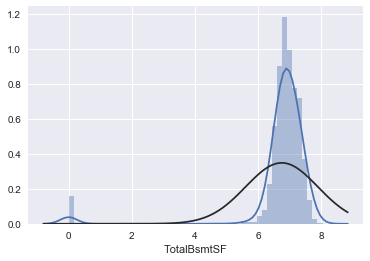

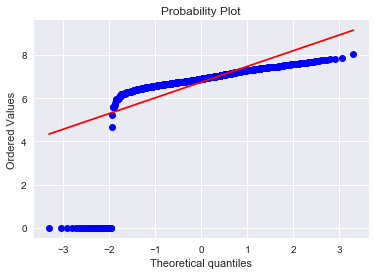

In [105]:
sns.distplot(train_df['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train_df['TotalBsmtSF'], plot=plt)

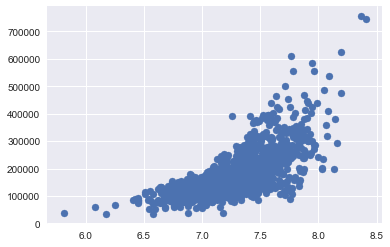

In [108]:
plt.scatter(train_df['GrLivArea'], train_df['SalePrice']);

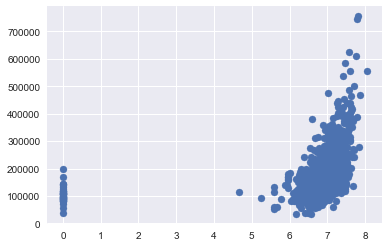

In [109]:
plt.scatter(train_df['TotalBsmtSF'], train_df['SalePrice']);

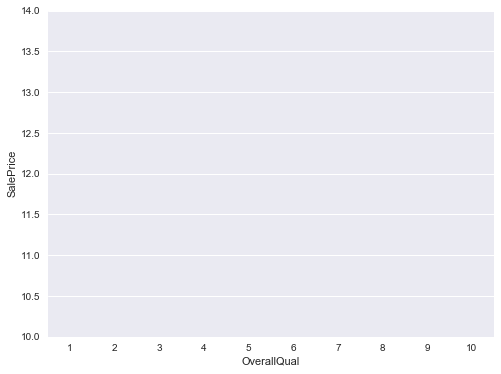

In [38]:
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=10, ymax=14);

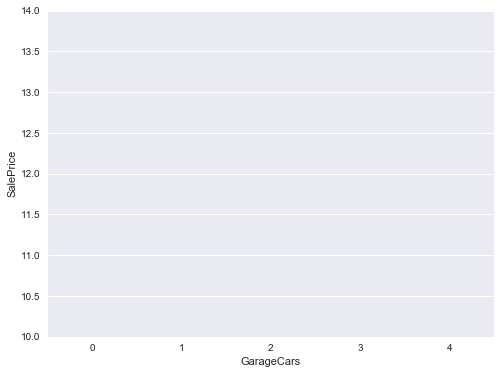

In [39]:
var = 'GarageCars'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=10, ymax=14);

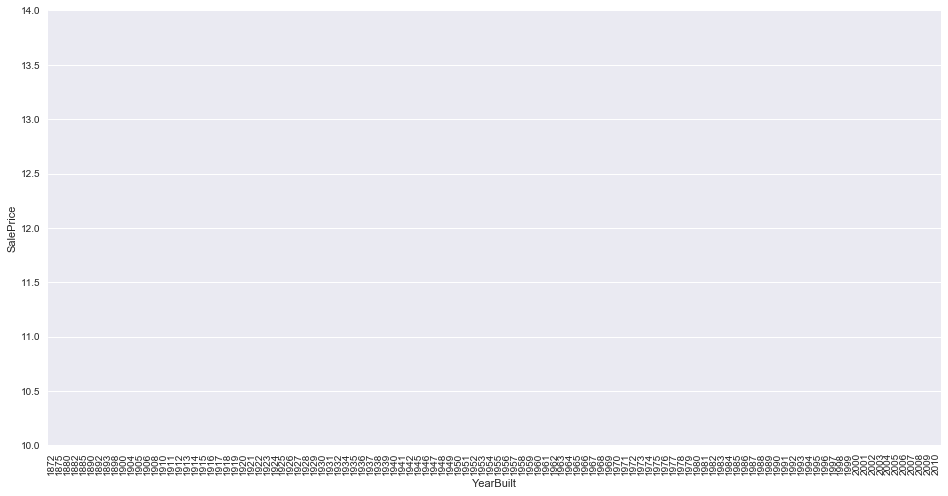

In [40]:
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=10, ymax=14);
plt.xticks(rotation=90);

In [138]:
train_df['YearBand'] = pd.qcut(train_df['YearBuilt'], 10)
train_df[['YearBand', 'SalePrice']].groupby(['YearBand'], as_index=False).mean().sort_values(by='YearBand', ascending=True)

ValueError: Bin edges must be unique: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]).
You can drop duplicate edges by setting the 'duplicates' kwarg

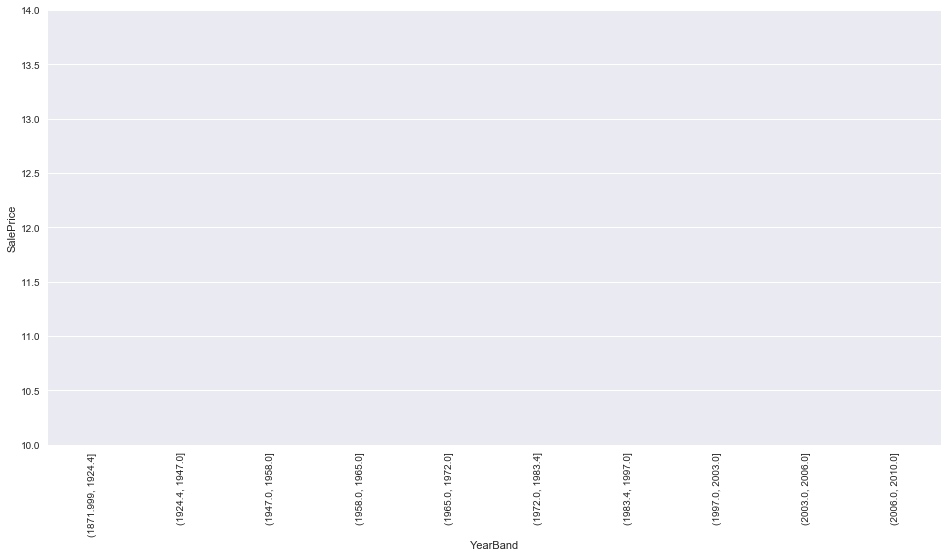

In [111]:
var = 'YearBand'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=10, ymax=14);
plt.xticks(rotation=90);

In [137]:
for dataset in combine:
    dataset.loc[ dataset['YearBuilt'] <= 1871.999, 'YearBuilt'] = 0
    dataset.loc[(dataset['YearBuilt'] > 1871.999) & (dataset['YearBuilt'] <= 1924.0), 'YearBuilt'] = 1
    dataset.loc[(dataset['YearBuilt'] > 1924.0) & (dataset['YearBuilt'] <= 1947.0), 'YearBuilt'] = 2
    dataset.loc[(dataset['YearBuilt'] > 1947.0) & (dataset['YearBuilt'] <= 1958.0), 'YearBuilt'] = 3
    dataset.loc[(dataset['YearBuilt'] > 1958.0) & (dataset['YearBuilt'] <= 1966.0), 'YearBuilt'] = 4
    dataset.loc[(dataset['YearBuilt'] > 1966.0) & (dataset['YearBuilt'] <= 1973.0), 'YearBuilt'] = 5
    dataset.loc[(dataset['YearBuilt'] > 1973.0) & (dataset['YearBuilt'] <= 1985.2), 'YearBuilt'] = 6
    dataset.loc[(dataset['YearBuilt'] > 1985.2) & (dataset['YearBuilt'] <= 1998.0), 'YearBuilt'] = 7
    dataset.loc[(dataset['YearBuilt'] > 1998.0) & (dataset['YearBuilt'] <= 2003.0), 'YearBuilt'] = 8
    dataset.loc[(dataset['YearBuilt'] > 2003.0) & (dataset['YearBuilt'] <= 2006.0), 'YearBuilt'] = 9
    dataset.loc[(dataset['YearBuilt'] > 2006.0) & (dataset['YearBuilt'] <= 2010.0), 'YearBuilt'] = 10
    dataset.loc[ dataset['YearBuilt'] > 31, 'YearBuilt'] = 11
    dataset['YearBuilt'] = dataset['YearBuilt'].astype(int)

train_df = train_df.drop(['YearBand'], axis=1)
combine = [train_df, test_df]

ValueError: labels ['YearBand'] not contained in axis

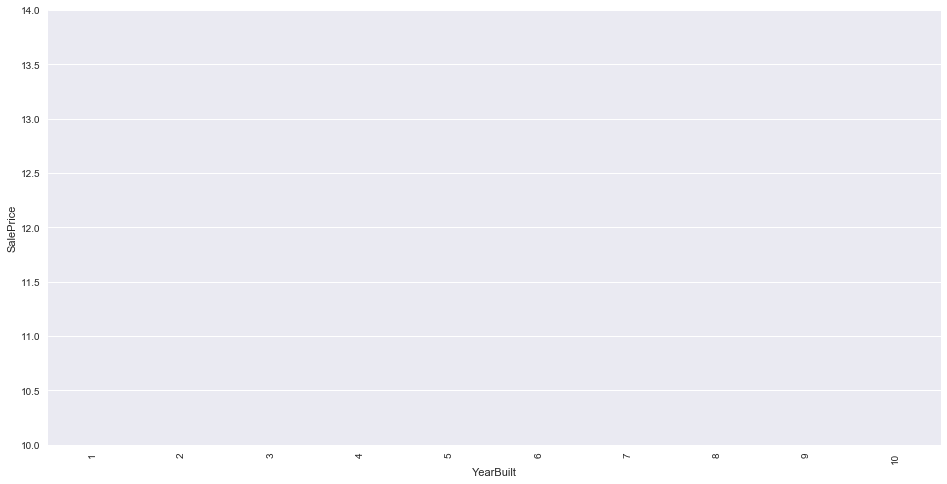

In [113]:
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=10, ymax=14);
plt.xticks(rotation=90);

In [114]:
x_df = train_df[['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'GarageCars', 'YearBuilt', 'SalePrice']]
x_df

,GrLivArea,TotalBsmtSF,OverallQual,GarageCars,YearBuilt,SalePrice
0,7.444249,6.752270,7,2,8,208500
1,7.140453,7.140453,6,2,6,181500
2,7.487734,6.824374,7,2,8,223500
3,7.448334,6.628041,7,3,1,140000
4,7.695303,7.043160,8,3,8,250000
5,7.216709,6.679599,5,2,7,143000
6,7.434848,7.430114,8,2,9,307000
7,7.644919,7.009409,7,2,5,200000
8,7.480992,6.858565,7,2,2,129900
9,6.981935,6.898715,5,1,2,118000


In [ ]:
'''x_features = x_data[['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'GarageCars', 'YearBuilt', 'SalePrice']]
MMScaler = MinMaxScaler(feature_range=(1,10))
x_features[['GrLivArea', 'TotalBsmtSF', 'YearBuilt']] = MMScaler.fit_transform(x_features[['GrLivArea', 'TotalBsmtSF', 'YearBuilt']])
x_features.head()'''

In [115]:
x_test_df = test_df[['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'GarageCars', 'YearBuilt']]
x_test_df.head()

,GrLivArea,TotalBsmtSF,OverallQual,GarageCars,YearBuilt
0,6.797940,6.782192,5,1.0,4
1,7.192182,7.192182,6,1.0,3
2,7.395722,6.833032,5,2.0,7
3,7.380256,6.830874,6,2.0,7
4,7.154615,7.154615,8,2.0,7


In [116]:
x_data = np.array(x_df.drop(['SalePrice'], axis=1))
y_data = np.array(x_df['SalePrice'])[:, np.newaxis]

x_test = np.array(x_test_df)
x_data.shape, y_data.shape, x_test.shape

((1455, 5), (1455, 1), (1459, 5))

In [128]:
tf.reset_default_graph()

In [129]:
# params
learning_rate = 0.001
training_epochs = 20
batch_size = 100
keep_prob = 0.7

X = tf.placeholder(tf.float32, [None, 5])
Y = tf.placeholder(tf.float32, [None, 1])
train_mode = tf.placeholder(tf.bool, name='train_mode')

hidden_output_size = 64
final_output_size = 1

variance_init = tf.contrib.layers.variance_scaling_initializer()
bn_params = {
    'is_training': train_mode,
    'decay': 0.9,
    'updates_collections': None
}


with arg_scope([fully_connected],
               activation_fn=tf.nn.relu,
               weights_initializer=variance_init,
               biases_initializer=None,
               normalizer_fn=batch_norm,
               normalizer_params=bn_params,
               reuse=None):
    hidden_layer1 = fully_connected(X, hidden_output_size, scope="h1")
    h1_drop = dropout(hidden_layer1, keep_prob, is_training=train_mode)
    hidden_layer2 = fully_connected(h1_drop, hidden_output_size, scope="h2")
    h2_drop = dropout(hidden_layer2, keep_prob, is_training=train_mode)
    hidden_layer3 = fully_connected(h2_drop, hidden_output_size, scope="h3")
    h3_drop = dropout(hidden_layer3, keep_prob, is_training=train_mode)
    hidden_layer4 = fully_connected(h3_drop, hidden_output_size, scope="h4")
    h4_drop = dropout(hidden_layer4, keep_prob, is_training=train_mode)
    hypothesis = fully_connected(
        h4_drop, final_output_size, activation_fn=None, scope="hypothesis")
    
    cost = tf.reduce_mean(tf.square(hypothesis - Y))

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train
for epoch in tqdm(range(training_epochs)):
    feed_dict_train = {X: x_data, Y: y_data, train_mode: True}
    feed_dict_cost = {X: x_test, train_mode: False}
    
    c, _ = sess.run([cost, optimizer], feed_dict=feed_dict_train)
    print("[Epoch: {:>4}] cost = {:>.9}".format(epoch + 1, c))

print('Learning Finished!')


In [130]:
with tf.variable_scope('cell', reuse=None) as scope:
    W = tf.get_variable("Weight", shape=[5, 1],
                     initializer= tf.contrib.layers.variance_scaling_initializer())
    b = tf.Variable(tf.random_normal([1]), name='bias')

# Hypothesis
hypothesis = tf.matmul(X, W) + b

# Simplified cost/loss function
cost = tf.reduce_mean(tf.square(hypothesis - Y))

# Minimize
optimizer = tf.train.AdamOptimizer(learning_rate=20000)
train = optimizer.minimize(cost)

# Launch the graph in a session.
sess = tf.Session()
# Initializes global variables in the graph.
sess.run(tf.global_variables_initializer())

for step in tqdm(range(20001)):
    cost_val, hy_val, _ = sess.run(
        [cost, hypothesis, train], feed_dict={X: x_data, Y: y_data})
    if step % 10 == 0:
        print(step, "Cost: ", cost_val)

0 Cost:  3.89312e+10
10 Cost:  1.49105e+10
20 Cost:  3.72909e+09
30 Cost:  2.7007e+09
40 Cost:  3.57319e+09
50 Cost:  2.67522e+09
60 Cost:  2.31217e+09
70 Cost:  2.20363e+09
80 Cost:  2.18784e+09
90 Cost:  2.15194e+09
100 Cost:  2.13377e+09
110 Cost:  2.12419e+09
120 Cost:  2.11775e+09
130 Cost:  2.11263e+09
140 Cost:  2.10814e+09
150 Cost:  2.10396e+09
160 Cost:  2.09988e+09
170 Cost:  2.09576e+09
180 Cost:  2.09157e+09
190 Cost:  2.08731e+09
200 Cost:  2.08296e+09
210 Cost:  2.07854e+09
220 Cost:  2.07404e+09
230 Cost:  2.06947e+09
240 Cost:  2.06484e+09
250 Cost:  2.06015e+09
260 Cost:  2.0554e+09
270 Cost:  2.05061e+09
280 Cost:  2.04576e+09
290 Cost:  2.04087e+09
300 Cost:  2.03595e+09
310 Cost:  2.03098e+09
320 Cost:  2.02599e+09
330 Cost:  2.02097e+09
340 Cost:  2.01592e+09
350 Cost:  2.01085e+09
360 Cost:  2.00576e+09
370 Cost:  2.00065e+09
380 Cost:  1.99553e+09
390 Cost:  1.9904e+09
400 Cost:  1.98526e+09
410 Cost:  1.98012e+09
420 Cost:  1.97498e+09
430 Cost:  1.96984e+09
44

3550 Cost:  1.62864e+09
3560 Cost:  1.62864e+09
3570 Cost:  1.62864e+09
3580 Cost:  1.62868e+09
3590 Cost:  1.63353e+09
3600 Cost:  2.84228e+09
3610 Cost:  3.18112e+09
3620 Cost:  1.81718e+09
3630 Cost:  1.7995e+09
3640 Cost:  1.74594e+09
3650 Cost:  1.68427e+09
3660 Cost:  1.64962e+09
3670 Cost:  1.63504e+09
3680 Cost:  1.62992e+09
3690 Cost:  1.62868e+09
3700 Cost:  1.62872e+09
3710 Cost:  1.62879e+09
3720 Cost:  1.62867e+09
3730 Cost:  1.62863e+09
3740 Cost:  1.62864e+09
3750 Cost:  1.62863e+09
3760 Cost:  1.62863e+09
3770 Cost:  1.62863e+09
3780 Cost:  1.62863e+09
3790 Cost:  1.62863e+09
3800 Cost:  1.62863e+09
3810 Cost:  1.62863e+09
3820 Cost:  1.62862e+09
3830 Cost:  1.62862e+09
3840 Cost:  1.62862e+09
3850 Cost:  1.62862e+09
3860 Cost:  1.62862e+09
3870 Cost:  1.62862e+09
3880 Cost:  1.62862e+09
3890 Cost:  1.62866e+09
3900 Cost:  1.63256e+09
3910 Cost:  2.38388e+09
3920 Cost:  1.63013e+09
3930 Cost:  2.171e+09
3940 Cost:  1.85664e+09
3950 Cost:  1.71299e+09
3960 Cost:  1.6671e

7040 Cost:  1.62861e+09
7050 Cost:  1.62863e+09
7060 Cost:  1.62863e+09
7070 Cost:  1.62862e+09
7080 Cost:  1.62861e+09
7090 Cost:  1.62861e+09
7100 Cost:  1.62861e+09
7110 Cost:  1.62861e+09
7120 Cost:  1.62861e+09
7130 Cost:  1.62861e+09
7140 Cost:  1.62861e+09
7150 Cost:  1.62861e+09
7160 Cost:  1.62861e+09
7170 Cost:  1.62861e+09
7180 Cost:  1.62861e+09
7190 Cost:  1.62861e+09
7200 Cost:  1.62861e+09
7210 Cost:  1.62861e+09
7220 Cost:  1.62861e+09
7230 Cost:  1.62861e+09
7240 Cost:  1.62861e+09
7250 Cost:  1.62861e+09
7260 Cost:  1.62864e+09
7270 Cost:  1.6353e+09
7280 Cost:  3.96597e+09
7290 Cost:  7.11621e+09
7300 Cost:  3.55912e+09
7310 Cost:  2.11639e+09
7320 Cost:  1.66153e+09
7330 Cost:  1.63127e+09
7340 Cost:  1.63873e+09
7350 Cost:  1.63544e+09
7360 Cost:  1.6316e+09
7370 Cost:  1.62969e+09
7380 Cost:  1.62893e+09
7390 Cost:  1.62867e+09
7400 Cost:  1.62861e+09
7410 Cost:  1.62862e+09
7420 Cost:  1.62862e+09
7430 Cost:  1.62861e+09
7440 Cost:  1.62861e+09
7450 Cost:  1.6286

10500 Cost:  1.62868e+09
10510 Cost:  1.62894e+09
10520 Cost:  1.62892e+09
10530 Cost:  1.62871e+09
10540 Cost:  1.62861e+09
10550 Cost:  1.62862e+09
10560 Cost:  1.62861e+09
10570 Cost:  1.62861e+09
10580 Cost:  1.62861e+09
10590 Cost:  1.62861e+09
10600 Cost:  1.62861e+09
10610 Cost:  1.62861e+09
10620 Cost:  1.62861e+09
10630 Cost:  1.62861e+09
10640 Cost:  1.62861e+09
10650 Cost:  1.62861e+09
10660 Cost:  1.62861e+09
10670 Cost:  1.62861e+09
10680 Cost:  1.62861e+09
10690 Cost:  1.62861e+09
10700 Cost:  1.62861e+09
10710 Cost:  1.62861e+09
10720 Cost:  1.62863e+09
10730 Cost:  1.63105e+09
10740 Cost:  2.34147e+09
10750 Cost:  1.68507e+09
10760 Cost:  1.63178e+09
10770 Cost:  1.73617e+09
10780 Cost:  1.79144e+09
10790 Cost:  1.7208e+09
10800 Cost:  1.66431e+09
10810 Cost:  1.64094e+09
10820 Cost:  1.63299e+09
10830 Cost:  1.63024e+09
10840 Cost:  1.62917e+09
10850 Cost:  1.62874e+09
10860 Cost:  1.62862e+09
10870 Cost:  1.62862e+09
10880 Cost:  1.62862e+09
10890 Cost:  1.62861e+09
1

13870 Cost:  1.62877e+09
13880 Cost:  1.62869e+09
13890 Cost:  1.62863e+09
13900 Cost:  1.62861e+09
13910 Cost:  1.62861e+09
13920 Cost:  1.62861e+09
13930 Cost:  1.62861e+09
13940 Cost:  1.62861e+09
13950 Cost:  1.62861e+09
13960 Cost:  1.62861e+09
13970 Cost:  1.62861e+09
13980 Cost:  1.62861e+09
13990 Cost:  1.62861e+09
14000 Cost:  1.62861e+09
14010 Cost:  1.62861e+09
14020 Cost:  1.62861e+09
14030 Cost:  1.62861e+09
14040 Cost:  1.62861e+09
14050 Cost:  1.62861e+09
14060 Cost:  1.62861e+09
14070 Cost:  1.62861e+09
14080 Cost:  1.62861e+09
14090 Cost:  1.62864e+09
14100 Cost:  1.63357e+09
14110 Cost:  3.30978e+09
14120 Cost:  5.8442e+09
14130 Cost:  3.24666e+09
14140 Cost:  2.33282e+09
14150 Cost:  1.77541e+09
14160 Cost:  1.63828e+09
14170 Cost:  1.62882e+09
14180 Cost:  1.63003e+09
14190 Cost:  1.62953e+09
14200 Cost:  1.62892e+09
14210 Cost:  1.62866e+09
14220 Cost:  1.62861e+09
14230 Cost:  1.62863e+09
14240 Cost:  1.62863e+09
14250 Cost:  1.62862e+09
14260 Cost:  1.62861e+09
1

17150 Cost:  1.63142e+09
17160 Cost:  2.8958e+09
17170 Cost:  5.56226e+09
17180 Cost:  3.73613e+09
17190 Cost:  2.24039e+09
17200 Cost:  1.6299e+09
17210 Cost:  1.68587e+09
17220 Cost:  1.66547e+09
17230 Cost:  1.63599e+09
17240 Cost:  1.62906e+09
17250 Cost:  1.62862e+09
17260 Cost:  1.62867e+09
17270 Cost:  1.62865e+09
17280 Cost:  1.62862e+09
17290 Cost:  1.62861e+09
17300 Cost:  1.62861e+09
17310 Cost:  1.62861e+09
17320 Cost:  1.62861e+09
17330 Cost:  1.62861e+09
17340 Cost:  1.62861e+09
17350 Cost:  1.62861e+09
17360 Cost:  1.62861e+09
17370 Cost:  1.62861e+09
17380 Cost:  1.62861e+09
17390 Cost:  1.62861e+09
17400 Cost:  1.62861e+09
17410 Cost:  1.62861e+09
17420 Cost:  1.62861e+09
17430 Cost:  1.62861e+09
17440 Cost:  1.62861e+09
17450 Cost:  1.62861e+09
17460 Cost:  1.62861e+09
17470 Cost:  1.62861e+09
17480 Cost:  1.62861e+09
17490 Cost:  1.62861e+09
17500 Cost:  1.62861e+09
17510 Cost:  1.62861e+09
17520 Cost:  1.62861e+09
17530 Cost:  1.6287e+09
17540 Cost:  1.66361e+09
175

In [131]:
predict = hypothesis / Y
accuracy = tf.reduce_mean(predict)

In [132]:
y_test = np.array(result_df['SalePrice'])[:, np.newaxis]
len(y_test)

1459

In [133]:
resData = np.asarray(sess.run(hypothesis, feed_dict={X: x_test}))
resData

array([[ 101038.5   ],
       [ 154842.75  ],
       [ 174301.0625],
       ..., 
       [ 143745.5   ],
       [ 100041.9375],
       [ 254854.5625]], dtype=float32)

In [134]:
#resData1 = np.exp(resData)
resData1 = np.absolute(resData)
resData1 = np.reshape(resData1, (-1, 1)).astype(float)
resData1 = resData1.flatten()
resData1 = resData1[:, np.newaxis]
resData1

array([[ 101038.5   ],
       [ 154842.75  ],
       [ 174301.0625],
       ..., 
       [ 143745.5   ],
       [ 100041.9375],
       [ 254854.5625]])

In [135]:
print(resData1)
np.savetxt('./test.csv', resData, delimiter=",")
res = np.array([i + 1461 for i in range(len(resData1))])[:, np.newaxis]
print(res)
res1 = np.hstack((res,resData1))
print(res1.shape)

[[ 101038.5   ]
 [ 154842.75  ]
 [ 174301.0625]
 ..., 
 [ 143745.5   ]
 [ 100041.9375]
 [ 254854.5625]]
[[1461]
 [1462]
 [1463]
 ..., 
 [2917]
 [2918]
 [2919]]
(1459, 2)


In [136]:
np.savetxt('./result.csv', res1, delimiter=",")